In [1]:
from typing_extensions import TypedDict
class State(TypedDict):
    xyz:str
    abc:str

In [2]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def node(state:OverallState):
    return {"a": "Hi I'm Saurabh"}

In [3]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START, 'node')
builder.add_edge("node", END)
graph = builder.compile()

In [4]:
graph.invoke({"a":"Hello"})

{'a': "Hi I'm Saurabh"}

In [5]:
graph.invoke({"a":'1'})

{'a': "Hi I'm Saurabh"}

In [6]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

def bad_node(state: OverallState):
    return {
        "a":"123"
    }

def ok_node(state: OverallState):
    return {"a":"goodbye"}

builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", 'ok_node')
builder.add_edge("ok_node", END)
graph = builder.compile()

In [7]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "Sau"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

In [8]:
graph.invoke({"a": "Sau"})

{'a': 'goodbye'}

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen-2.5-32b")

result = llm.invoke("Hello")
result.content

'Hello! How can I assist you today?'

In [10]:
from typing_extensions import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str
    updated_joke: str
    final_joke: str
    

In [11]:
# Nodes
def generate_joke(state:State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Get function to check if the joke have punchline"""
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state:State):
    """Second LLM call to improve the joke"""
    msg = llm.invoke(f"Make this joke funnier by adding wordplay:  {state['joke']}")
    return {"updated_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for Final Polish"""
    msg = llm.invoke(f"Add a surprising twish to this joke: {state['updated_joke']}")
    return {"final_joke": msg.content}


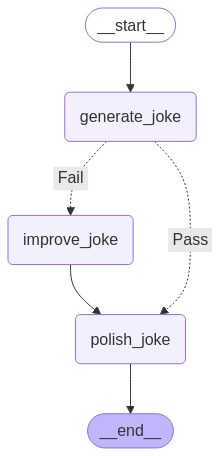

In [12]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build Workflow
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add Edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Fail":"improve_joke", "Pass":"polish_joke"})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()


# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [13]:
# invoke 
state = chain.invoke({"topic":"cats"})

In [14]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'updated_joke': "Why don't cats play poker in the wild? Because every game ends with a spot of cheetah spottin'!",
 'final_joke': "Why don't cats play poker in the wild? Because every game ends with a spot of cheetah spottin', and the cheetah always wins by bluffing with a spots flush!"}

In [30]:
state['updated_joke']

"Why don't cats play poker in the wild? Because every game gets clawsed when there are too many cheetahs around!"

In [28]:
state['final_joke']

"Why don't cats play poker in the wild? Because every game gets clawsed when there are too many cheetahs around, especially since the cheetahs always insist on using their spots as a wild card!"

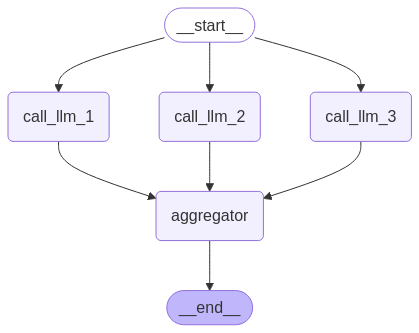

In [37]:
class PState(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str


def call_llm_1(state: PState):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

def call_llm_2(state: PState):
    """Second LLM call to generate initial story"""
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

def call_llm_3(state: PState):
    """Third LLM call to generate initial poem"""
    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

def aggregator(state: PState):
    """Combine the joke and story into a single output"""
    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


# Build workflow
parallel_builder = StateGraph(PState)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)


# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [38]:
# Invoke
state = parallel_workflow.invoke({"topic": "cats"})
# print(state["combined_output"])

In [39]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheetahs!",
 'story': "In the heart of a bustling city, nestled between towering skyscrapers, there was a small, cozy alleyway known as Whisper Alley. Despite its name, it was anything but lonely. It was a sanctuary for the most curious and endearing creatures—cats. These weren't just any cats; they were the guardians of Whisper Alley, each with its unique charm and a story to tell.\n\nThere was Luna, the silver-furred feline who always seemed to know where the fish market workers would toss out their extra scraps. With her keen sense of smell and agility, she could catch them before they hit the ground, making her the queen of the alley. Then there was Miko, the orange tabby, who was known for his playful antics and his unusual talent for unlocking the dumpsters behind the nearby restaurants, providing not only food but also a source of joy and entertainment for the other alley residents.\n\n

In [ ]:
from typing import Annotated, List
import operator

# Scheme for 

## Human in loop

In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen-2.5-32b")
result = llm.invoke("Hello")
resutl

BadRequestError: Error code: 400 - {'error': {'message': 'The model `mixtral-8x7b-32768` has been decommissioned and is no longer supported. Please refer to https://console.groq.com/docs/deprecations for a recommendation on which model to use instead.', 'type': 'invalid_request_error', 'code': 'model_decommissioned'}}

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_community.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

# Hypothetical model path, replace with exact name from Hugging Face when available
model_name = "deepseek-ai/DeepSeek-R1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto")

# Create a pipeline with reasonable settings
hf_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, max_length=100)

# Integrate with LangChain
llm = HuggingFacePipeline(pipeline=hf_pipeline)

result = llm.invoke("Hello")
print(result)

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-R1:
- modeling_deepseek.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`

In [ ]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm_with_tools=llm.bind_tools(tools)

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System msg
sys_msg = SystemMessage(content="You are helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState)